# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [ ]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

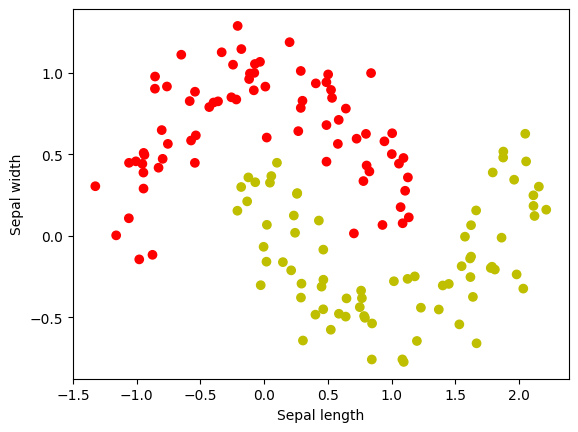

In [ ]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [ ]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [ ]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [ ]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [ ]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [ ]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.2138)


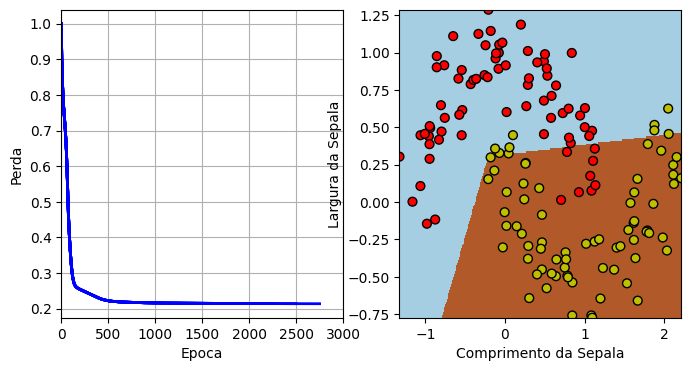

In [ ]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [ ]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[-1.5116, -0.1517],
        [-0.9233,  0.3201],
        [ 0.0520,  0.5346],
        [ 0.0925, -0.9666],
        [ 0.1604, -0.2793]])
dense.0.bias    torch.Size([5])
tensor([-0.2954, -0.2621,  1.2991,  1.3212, -0.7018])
dense.2.weight  torch.Size([5, 5])
tensor([[ 0.1619, -0.4345, -0.1610, -0.1012,  0.0825],
        [ 0.1452,  0.3719,  0.0132, -0.3491, -0.2604],
        [ 0.4707,  0.4965,  1.3106, -0.0731, -0.0137],
        [-0.5145, -0.6687,  0.2247,  0.6354, -0.4199],
        [-1.3355, -0.6503,  0.0804,  1.5323, -0.1144]])
dense.2.bias    torch.Size([5])
tensor([-0.0129, -0.0998,  1.4423, -0.1070,  0.0676])
dense.4.weight  torch.Size([3, 5])
tensor([[ 0.3206, -0.1793,  1.4275, -0.7213, -1.4286],
        [ 0.1609, -0.0335, -0.4712,  0.7719,  1.5792],
        [ 0.3948,  0.1678, -1.4338,  0.2076, -0.0562]])
dense.4.bias    torch.Size([3])
tensor([ 0.7280,  0.4679, -1.4047])


### Avaliação do classificador

In [ ]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.8866666666666667


### Matriz de confusão

In [ ]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,67,9
1,8,66


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

In [ ]:
# metodo para treinamento
def train_model(model):
  lr = 0.15

  optimizer = torch.optim.SGD(model.parameters(), lr=lr)

  criterion = nn.CrossEntropyLoss()

  batch_size = 150
  nb_epoch = 3000

  #Definindo o plotter
  boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

  boundary_plot.on_train_begin()
  losses = []
  for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

  print('Final loss:', loss.data)

  return model, losses

### 1


In [ ]:
# alteracao na camada intermediaria
class Modelo_v1(nn.Module):
    def __init__(self):
        super(Modelo_v1, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model_v1 = Modelo_v1()
print(model_v1)

Modelo_v1(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2040)


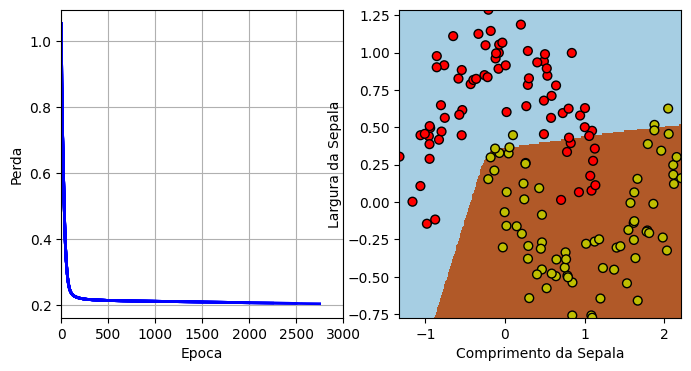

In [ ]:
model_v1, losses_v1 = train_model(model_v1)

In [ ]:
Y_hat = predict(model_v1, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9133333333333333


In [ ]:
# alteracao na camada intermediaria
class Modelo_v2(nn.Module):
    def __init__(self):
        super(Modelo_v2, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 42),
            nn.ReLU(),
            nn.Linear(42, 42),
            nn.ReLU(),
            nn.Linear(42,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model_v2 = Modelo_v2()
print(model_v2)

Modelo_v2(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=42, bias=True)
    (1): ReLU()
    (2): Linear(in_features=42, out_features=42, bias=True)
    (3): ReLU()
    (4): Linear(in_features=42, out_features=3, bias=True)
  )
)


Final loss: tensor(0.0016)


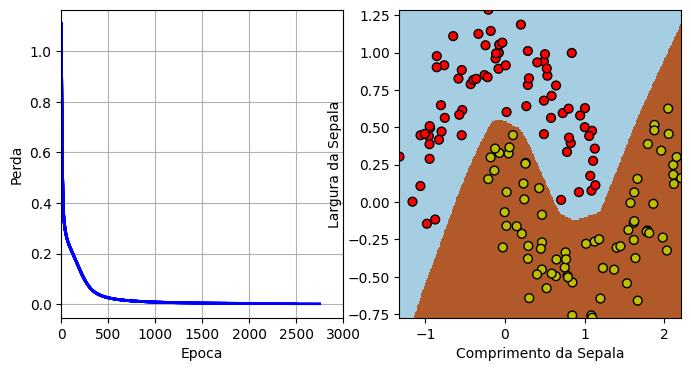

In [ ]:
model_v2, losses_v2 = train_model(model_v2)

In [ ]:
Y_hat = predict(model_v2, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


In [ ]:
# alteracao na qtd de camadas ocultas e qtd neuronios
class Modelo_v3(nn.Module):
    def __init__(self):
        super(Modelo_v3, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model_v3 = Modelo_v3()
print(model_v3)

Modelo_v3(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


Final loss: tensor(0.0004)


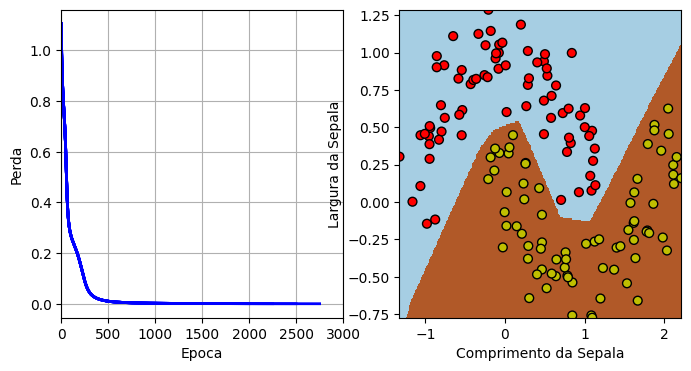

In [ ]:
model_v3, losses_v3 = train_model(model_v3)

In [ ]:
Y_hat = predict(model_v3, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  1.0


Fazendo o aumento de número de neurônios e camadas, o modelo tende a demorar mais para treinar, além de mais tempo para "aprender" (a taxa de loss demora mais pra cair), entretanto, o modelo tende a ter uma melhor acurácia, visto que é um modelo mais robusto para um problema "simples".

Deste modo, deve-se sempre ponderar perfomance com qualidade do modelo criado/treinado.

### 2

In [ ]:
# alteracao na camada intermediaria
class Modelo_v4(nn.Module):
    def __init__(self):
        super(Modelo_v4, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Sigmoid(),
            nn.Linear(10,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model_v4 = Modelo_v4()
print(model_v4)

Modelo_v4(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2517)


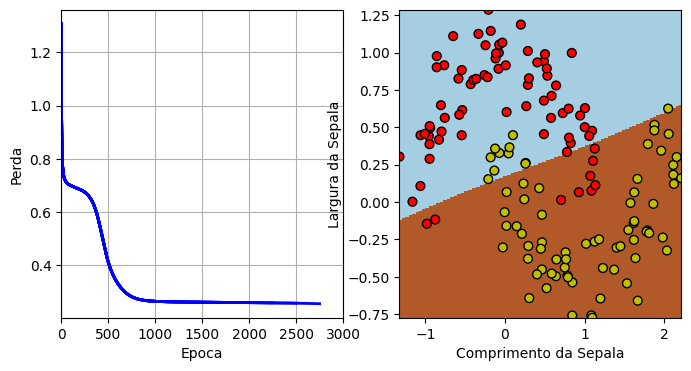

In [ ]:
model_v4, losses_v4 = train_model(model_v4)

In [ ]:
# alteracao na camada intermediaria
class Modelo_v5(nn.Module):
    def __init__(self):
        super(Modelo_v5, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 8),
            nn.Sigmoid(),
            nn.Linear(8, 16),
            nn.Sigmoid(),
            nn.Linear(16, 8),
            nn.Sigmoid(),
            nn.Linear(8,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model_v5 = Modelo_v5()
print(model_v5)

Modelo_v5(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=8, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2605)


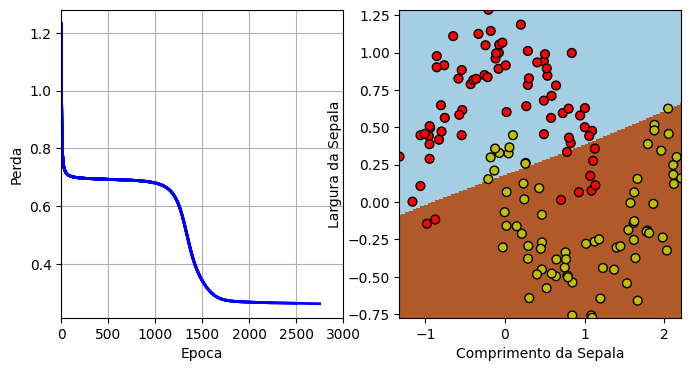

In [ ]:
model_v5, losses_v5 = train_model(model_v5)

Adicionando a sigmoide, o aprendizado se torna mais linear, de forma que a separação não funcionou bem. Entretanto, é provável que com o aumento de neurônios e camadas, a função sigmoide poderia sim funcionar para os dados, mas o tempo de treinamento seria muito longo para que a rede realizasse as subdivisões lineares necessárias para entender o problema.

### 3


P - O que ocorre quando não se utiliza ativação não linear entre camadas?

R - O modelo irá será apenas um regressão linear, o que não se aplica ao nossos dados.

In [ ]:
class Modelo_linear(nn.Module):
    def __init__(self):
        super(Modelo_linear, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 8),
            nn.Linear(8, 16),
            nn.Linear(16, 8),
            nn.Linear(8,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

linear_model = Modelo_linear()
print(linear_model)

Modelo_linear(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=3, bias=True)
  )
)


Final loss: tensor(0.2547)


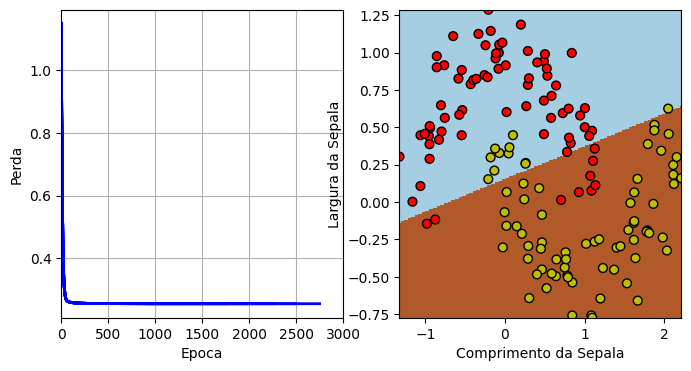

In [ ]:
linear_model, losses_linear = train_model(linear_model)

## Principais aprendizados


*   Composição de redes com diferentes números de neurônios e camadas, além do entidmento da sua consquência no aprendizado da rede.
*   Influência diferentes funções de ativação sobre a arquitetura da rede elaborada.

